# 1. Install relevant libraries

In [1]:
!pip install torch-explain

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# 2. Import relevant libraries

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch_explain as te
from torch_explain import datasets

# 3. Load the dataset and feed it into the Data Loader

In [3]:
# Dataset loaded
x, c, y = datasets.xor(500)

# Quick visualisation (displays the first 5 values of each tensor)
print("Sample x values:", x[:5])
print("Sample c values:", c[:5])
print("Sample y values:", y[:5])

Sample x values: tensor([[0.3745, 0.9507],
        [0.7320, 0.5987],
        [0.1560, 0.1560],
        [0.0581, 0.8662],
        [0.6011, 0.7081]])
Sample c values: tensor([[0., 1.],
        [1., 1.],
        [0., 0.],
        [0., 1.],
        [1., 1.]])
Sample y values: tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]])


For reference, the dataset is produced using the following code:
```
def xor(size, random_state=42):
    # sample from normal distribution
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, (size, 2))
    c = np.stack([
        x[:, 0] > 0.5,
        x[:, 1] > 0.5,
    ]).T
    y = np.logical_xor(c[:, 0], c[:, 1])

    x = torch.FloatTensor(x)
    c = torch.FloatTensor(c)
    y = torch.FloatTensor(y)
    return x, c, y.unsqueeze(-1)
```

To pass the XOR dataset from the Pytorch Explain library into a DataLoader, I first need to create a custom dataset class using PyTorch's Dataset interface. This class will manage the tensors (x, c, and y) obtained from the xor function. Then, I can utilize a DataLoader to handle batching and shuffling (if necessary) for training or evaluation.

Note that the DataLoader uses uses the \_\_getitem\_\_ method of XORDataset to fetch data in batches.


In [4]:
# Will use this class in order to provide batches for DataLoader
class XORdataset(Dataset):
    def __init__(self, x, c, y):
        self.x = x
        self.c = c
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.c[idx], self.y[idx]

In [5]:
def createDataLoader(x_dataset, c_dataset, y_dataset, batch_size):
  # Using the datasets generated above, split it into training and testing data
  x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(x_dataset, c_dataset, y_dataset, test_size=0.33, random_state=42)

  # Create instances of the XORdataset for training and testing
  train_dataset = XORdataset(x_train, c_train, y_train)
  test_dataset = XORdataset(x_test, c_test, y_test)

  # Define the batch size
  loader_batch_size = batch_size

  # Create DataLoader instances for training and testing
  train_loader = DataLoader(train_dataset, batch_size=loader_batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=loader_batch_size, shuffle=False)

  return train_loader, test_loader

# Extra: View dataset and batch in data loader

In [6]:
# Just for my own testing and viewing
visualising_dataset = XORdataset(x, c, y)

# Access the data at index 5
sample_x, sample_c, sample_y = visualising_dataset[5]

# Print the retrieved data to see the values
print("Sample x value:", sample_x)
print("Sample c value:", sample_c)
print("Sample y value:", sample_y)

visualising_train_loader, visualising_test_loader = createDataLoader(x, c, y, 5)

# Fetch the first batch from the training DataLoader
first_batch = next(iter(visualising_train_loader))

# Unpack the first batch
x_batch, c_batch, y_batch = first_batch

# Print the values (number of values depends on batch_size)
print("First batch x values:", x_batch)
print("First batch c values:", c_batch)
print("First batch y values:", y_batch)

# Another method for accessing one batch at a time (used later)
i = 0
for i, batch in enumerate(visualising_train_loader):
  if i == 0:
    x_batch, c_batch, y_batch = batch
    print("First batch c values:", c_batch)
  i+=1

Sample x value: tensor([0.0206, 0.9699])
Sample c value: tensor([0., 1.])
Sample y value: tensor([1.])
First batch x values: tensor([[0.5868, 0.7454],
        [0.0759, 0.1289],
        [0.0712, 0.3190],
        [0.1182, 0.6967],
        [0.5544, 0.6117]])
First batch c values: tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [1., 1.]])
First batch y values: tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.]])
First batch c values: tensor([[1., 1.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [1., 0.]])


# Extra: Looking at other people's work

Nikita's CBM

*Model*
*   In the initialiser the two linear layers are defined. The first layer transforms the input data into a hidden representation. The second layer trasforms the hidden representation into the final output.
*   `nn.Linear(size_of_input_sample, size_of_output_sample)`
*   The `forward` methods defines the forward pass of the model. A ReLU is used after the first linear layer to introduce non-linearity.  Softmax activation is applied after the last linear layer to obtain class probabilities.

```
# Nikita's Independent CBM Model

class model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        probabilities = F.softmax(x, dim=1)

        return probabilities
```


*Training*

* x_to_c: Maps input x to a latent concept c.
* c_to_y: Uses the concept c to predict the final output y.

This model performs multi-class classification as indicated by the use of softmax in the output layer and cross-entropy loss during training. Each stage (x_to_c and c_to_y) acts as a classifier, with x_to_c classifying inputs into latent concepts and c_to_y using these concepts to predict the final classes.

Epochs: The training is iterated for a given number of epochs.
Data Loading: Uses a data_loader to batch inputs and labels.
Backpropagation: Losses from both stages are used to update the models via backpropagation.

```
# Nikita's Independent CBM Training

def train(x_sz,c_sz, y_sz, c_dim, y_dim, lr, lr_2, epochs):
    # define the input and output sizes
    torch.manual_seed(25)
    x_to_c = model(x_sz, c_sz, c_dim)
    c_to_y = model(c_sz, y_sz, y_dim)


    # define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(x_to_c.parameters(), lr=lr)
    yoptimizer = torch.optim.SGD(c_to_y.parameters(), lr=lr_2)


    epochs_cnt = []
    xclosses = []
    cylosses = []
    pred_c_list = []
    correct_c = []
    pred_y_list = []
    correct_y = []

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_xc_loss = 0.0
        epochs_cnt.append(epoch)

        for i, batch in enumerate(data_loader):

            x, _, c = batch

            correct_c.append(c)

            x = x.to(x_to_c.linear1.weight.dtype)

            # forward pass

            # model.train()


            pred_c = x_to_c(x)
            pred_c_list.append(pred_c.detach().numpy())
            lossc = criterion(pred_c, c)


            # backward pass
            optimizer.zero_grad()
            lossc.backward()
            optimizer.step()

            running_xc_loss += lossc.item()

        xclosses.append(running_xc_loss/len(data_loader))

    for epoch in range(num_epochs):
        running_cy_loss = 0.0

        for i, batch in enumerate(data_loader):

            _, y, c = batch

            correct_y.append(y)

            pred_y = c_to_y(c)
            pred_y_list.append(pred_y.detach().numpy())
            lossy = criterion(pred_y, y)


            # backward pass
            yoptimizer.zero_grad()
            lossy.backward()
            yoptimizer.step()


            running_cy_loss += lossy.item()

        cylosses.append(running_cy_loss/len(data_loader))


    return xclosses, cylosses, pred_c_list, pred_y_list, epochs_cnt, correct_c, correct_y

```



# 4. Initialise Model

I am taking Nikita's structure but using sigmoid activation and Binary Cross Entropy loss because we are doing binary classification.

* In this case, `y` can either be 0 or 1, hence the prediction has to choose between two possible output labels.
* Furthermore, the output_size of the overall model is guaranteed to be 1, since the output is going to be binary.

In [7]:
class model(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        probability = torch.sigmoid(x)  # Sigmoid activation for binary classification
        return probability

# 5. Train the Model

In [16]:
def train(x_size, c_size, c_dimension, y_dimension, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, test_loader):
    torch.manual_seed(25)

    x_to_c = model(x_size, c_dimension, 2) # concept predictor (outputs 2 values)
    c_to_y = model(c_size, y_dimension, 1) # label predictor

    criterion = nn.BCELoss() # Binary cross-entropy loss
    x_to_c_optimiser = torch.optim.SGD(x_to_c.parameters(), lr = x_to_c_learning_rate)
    c_to_y_optimiser = torch.optim.SGD(c_to_y.parameters(), lr = c_to_y_learning_rate)

    # Initialising useful lists
    # For training
    x_to_c_loss_values, c_to_y_loss_values = [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    epochs_count = []
    ground_truth_c, ground_truth_y = [], []
    x_to_c_accuracy_values, c_to_y_accuracy_values = [], []
    # For testing
    x_to_c_test_loss_values, c_to_y_test_loss_values = [], []
    x_to_c_test_accuracy_values, c_to_y_test_accuracy_values = [], []

    for epoch in epochs:
      epochs_count.append(epoch)

      # Training Loop ==========================================================
      # Instantiating values for training
      running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
      x_to_c_correct, c_to_y_correct, total_samples = 0, 0, 0

      for i, batch in enumerate(train_loader):
        x, c, y = batch

        # Add ground truths from the dataset
        ground_truth_c.append(c)
        ground_truth_y.append(y)

        # Forward pass through x_to_c
        x = x.to(x_to_c.linear1.weight.dtype) # ensures data type of input tensor x matches data type of weights of the first linear layer
        predicted_c = x_to_c(x)
        x_to_c_predictions.append(predicted_c.detach().numpy())
        c_loss = criterion(predicted_c, c.float())

        # Backward pass and optimisation for x_to_c
        x_to_c_optimiser.zero_grad()
        c_loss.backward()
        x_to_c_optimiser.step()

        # Accumulate x_to_c loss value and correct predictions
        running_x_to_c_loss += c_loss.item()
        x_to_c_correct += ((predicted_c.round() == c).sum(dim=1) == 2).float().sum().item()

        # Forward pass through c_to_y
        predicted_y = c_to_y(c)
        c_to_y_predictions.append(predicted_y.detach().numpy())
        y_loss = criterion(predicted_y, y.float())

        # Backward pass and optimisation for x_to_c
        c_to_y_optimiser.zero_grad()
        y_loss.backward()
        c_to_y_optimiser.step()

        # Accumulate c_to_y loss value and correct predictions
        running_c_to_y_loss += y_loss.item()
        c_to_y_correct += (predicted_y.round() == y).float().sum().item()

        total_samples += len(y)

      x_to_c_loss_values.append(running_x_to_c_loss/len(train_loader))
      c_to_y_loss_values.append(running_c_to_y_loss/len(train_loader))
      x_to_c_accuracy_values.append(x_to_c_correct / total_samples)
      c_to_y_accuracy_values.append(c_to_y_correct / total_samples)

      # Testing Loop ===========================================================
      x_to_c.eval()
      c_to_y.eval()

      # Instantiating values for testing
      running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
      x_to_c_test_correct, c_to_y_test_correct, total_test_samples = 0, 0, 0

      with torch.no_grad():
        for x, c, y in test_loader:
            # Forward pass through x_to_c
            predicted_c = x_to_c(x.to(dtype=x_to_c.linear1.weight.dtype))
            c_loss = criterion(predicted_c, c.float())

            # Accumulate x_to_c loss and correct predictions for testing
            running_x_to_c_test_loss += c_loss.item()
            x_to_c_test_correct += ((predicted_c.round() == c).sum(dim=1) == 2).float().sum().item()

            # Forward pass through c_to_y
            predicted_y = c_to_y(c)
            y_loss = criterion(predicted_y, y.float())

            # Accumulate c_to_y loss and correct predictions for testing
            running_c_to_y_test_loss += y_loss.item()
            c_to_y_test_correct += (predicted_y.round() == y).float().sum().item()
            total_test_samples += len(y)

      x_to_c_test_loss_values.append(running_x_to_c_test_loss / len(test_loader))
      c_to_y_test_loss_values.append(running_c_to_y_test_loss / len(test_loader))
      x_to_c_test_accuracy_values.append(x_to_c_test_correct / total_test_samples)
      c_to_y_test_accuracy_values.append(c_to_y_test_correct / total_test_samples)

    return x_to_c, c_to_y, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, epochs_count, ground_truth_c, ground_truth_y, x_to_c_accuracy_values, c_to_y_accuracy_values, x_to_c_test_loss_values, c_to_y_test_loss_values, x_to_c_test_accuracy_values, c_to_y_test_accuracy_values

I have the non-cleaned training code here:



```
def train(x_size, c_size, c_dimension, y_dimension, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader):
    torch.manual_seed(25)

    x_to_c = model(x_size, c_dimension, 2) # concept predictor (outputs 2 values)
    c_to_y = model(c_size, y_dimension, 1) # label predictor

    criterion = nn.BCELoss() # Binary cross-entropy loss
    x_to_c_optimiser = torch.optim.SGD(x_to_c.parameters(), lr = x_to_c_learning_rate)
    c_to_y_optimiser = torch.optim.SGD(c_to_y.parameters(), lr = c_to_y_learning_rate)


    # Initialising useful lists
    x_to_c_loss_values = []
    c_to_y_loss_values = []

    x_to_c_predictions = []
    c_to_y_predictions = []

    epochs_count = []

    ground_truth_c = []
    ground_truth_y = []


    # Training loop
    for epoch in epochs:
      epochs_count.append(epoch)

      # Training loop for concept predictor model ===============================
      running_x_to_c_loss = 0.0

      for i, batch in enumerate(train_loader):
        x, c, _ = batch
        ground_truth_c.append(c)
        x = x.to(x_to_c.linear1.weight.dtype) # ensures data type of input tensor x matches data type of weights of the first linear layer

        predicted_c = x_to_c(x)
        x_to_c_predictions.append(predicted_c.detach().numpy())
        c_loss = criterion(predicted_c, c.float())

        x_to_c_optimiser.zero_grad()
        c_loss.backward()
        x_to_c_optimiser.step()

        running_x_to_c_loss += c_loss.item()

      x_to_c_loss_values.append(running_x_to_c_loss/len(train_loader))

      # Training loop for label predictor model =================================
      running_c_to_y_loss = 0.0

      for i, batch in enumerate(train_loader):
        _, c, y = batch
        ground_truth_y.append(y)

        predicted_y = c_to_y(c)
        c_to_y_predictions.append(predicted_y.detach().numpy())
        y_loss = criterion(predicted_y, y.float())

        c_to_y_optimiser.zero_grad()
        y_loss.backward()
        c_to_y_optimiser.step()

        running_c_to_y_loss += y_loss.item()

      c_to_y_loss_values.append(running_c_to_y_loss/len(train_loader))

    return x_to_c, c_to_y, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, epochs_count, ground_truth_c, ground_truth_y
```



In [17]:
# TRAINING

# Parameters
x_size = x.shape[1]
c_size = c.shape[1]
c_dimension = 10
y_dimension = 10
x_to_c_learning_rate = 0.01
c_to_y_learning_rate = 0.01
batch_size = 5
epochs = list(range(400))  # Training for N number of epochs

# Create the required data
train_loader, test_loader = createDataLoader(x, c, y, batch_size)

# Run the training
x_to_c, c_to_y, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, epochs_count, ground_truth_c, ground_truth_y, x_to_c_accuracy_values, c_to_y_accuracy_values, x_to_c_test_loss_values, c_to_y_test_loss_values, x_to_c_test_accuracy_values, c_to_y_test_accuracy_values = train(
        x_size, c_size, c_dimension, y_dimension, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, test_loader)

# 6. Training Evaluation

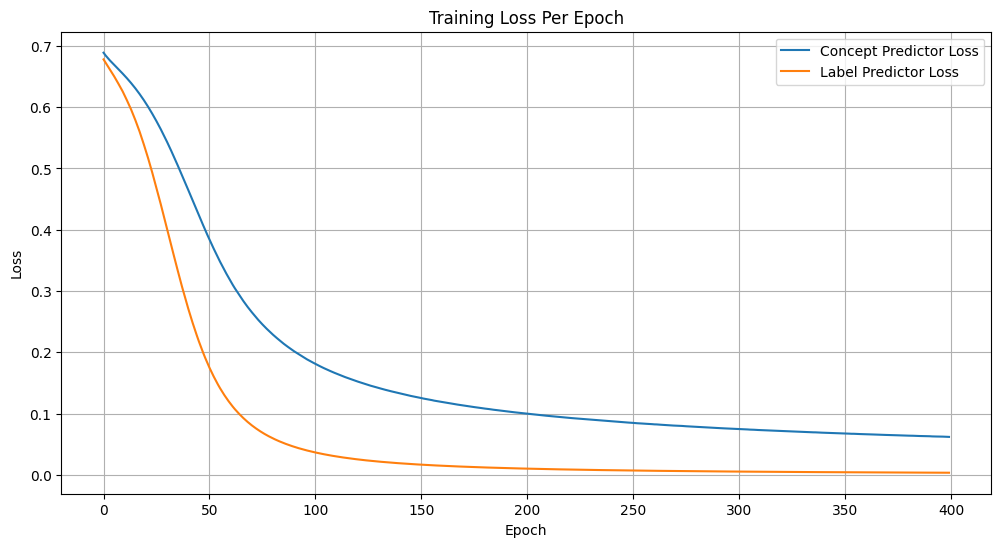

In [18]:
# RESULTS

# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Predictor Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

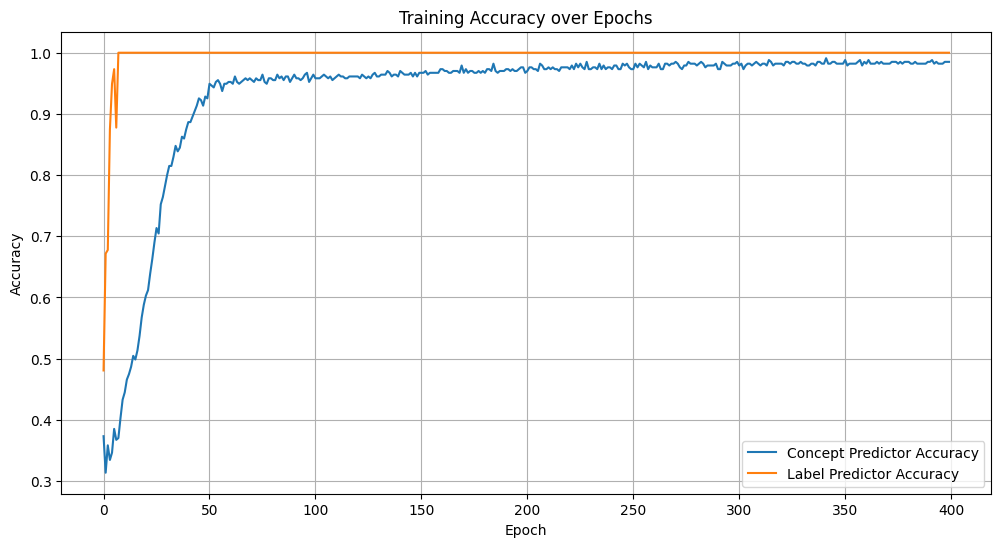

In [19]:
# Training accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_accuracy_values, label='Concept Predictor Accuracy')
plt.plot(epochs_count, c_to_y_accuracy_values, label='Label Predictor Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Evaluation metrics

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_metrics(predictions, ground_truth, loss_values):
    """
    Evaluate metrics for the model predictions against the ground truth labels.

    Args:
    predictions (list of np.array): List of predictions from each epoch (each array corresponds to an epoch).
    ground_truth (list of torch.Tensor): List of ground truth labels.
    loss_values (list): List of loss values for each epoch.

    Returns:
    dict: A dictionary containing evaluated metrics.
    """
    # Convert predictions and ground truths to a single array for evaluation
    predictions_flat = np.concatenate(predictions, axis=0)
    ground_truth_flat = np.concatenate([gt.numpy() for gt in ground_truth], axis=0)

    # Binarize predictions for accuracy, precision, recall calculation
    predictions_binarized = (predictions_flat > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(ground_truth_flat, predictions_binarized)
    precision = precision_score(ground_truth_flat, predictions_binarized, average='macro', zero_division=1)
    recall = recall_score(ground_truth_flat, predictions_binarized, average='macro')
    f1 = f1_score(ground_truth_flat, predictions_binarized, average='macro')
    mean_loss = np.mean(loss_values)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_loss": mean_loss
    }

x_to_c_metrics = evaluate_model_metrics(x_to_c_predictions, ground_truth_c, x_to_c_loss_values)
print("x_to_c model metrics:", x_to_c_metrics)

c_to_y_metrics = evaluate_model_metrics(c_to_y_predictions, ground_truth_y, c_to_y_loss_values)
print("c_to_y model metrics:", c_to_y_metrics)

x_to_c model metrics: {'accuracy': 0.9340671641791045, 'precision': 0.9406332337948335, 'recall': 0.9941120280549933, 'f1_score': 0.966514930724188, 'mean_loss': 0.17399152312105554}
c_to_y model metrics: {'accuracy': 0.9962611940298507, 'precision': 0.9962549487591006, 'recall': 0.9962683128965566, 'f1_score': 0.9962609470805649, 'mean_loss': 0.0746944699159462}


# 7. Test Evaluation



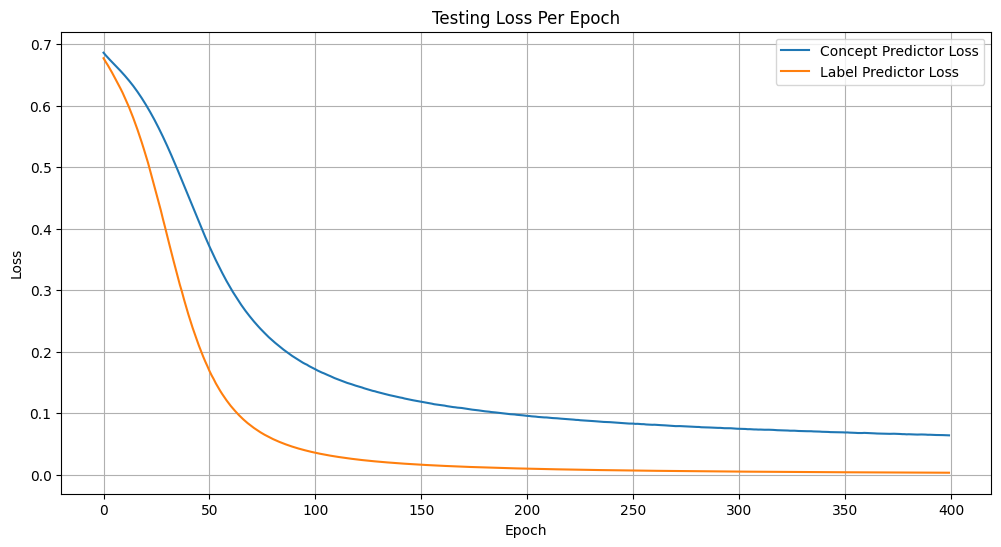

In [21]:
# RESULTS

# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_test_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_test_loss_values, label='Label Predictor Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

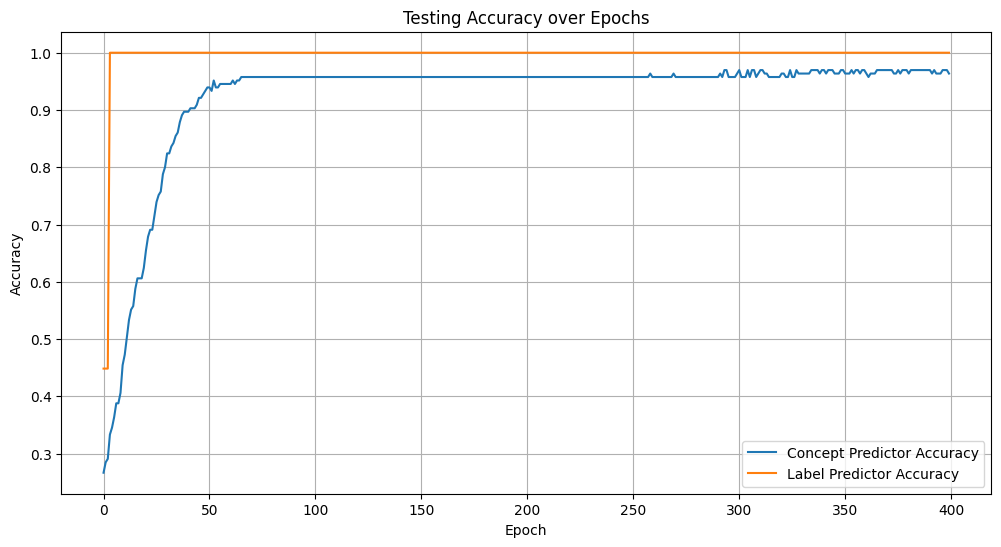

In [22]:
# Testing accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_test_accuracy_values, label='Concept Predictor Accuracy')
plt.plot(epochs_count,c_to_y_test_accuracy_values, label='Label Predictor Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def test_models(x_to_c, c_to_y, test_loader):
    criterion = nn.BCELoss()

    x_to_c.eval()
    c_to_y.eval()

    x_to_c_test_losses = []
    c_to_y_test_losses = []
    c_to_y_all_predictions = []
    c_to_y_all_ground_truths = []

    with torch.no_grad():
        for x, c, y in test_loader:
            # Testing x_to_c model
            x = x.to(dtype=x_to_c.linear1.weight.dtype)
            predicted_c = x_to_c(x)
            c_loss = criterion(predicted_c, c.float())
            x_to_c_test_losses.append(c_loss.item())

            # Testing c_to_y model
            predicted_y = c_to_y(predicted_c)  # Using the predicted concepts as input
            y_loss = criterion(predicted_y, y.float())
            c_to_y_test_losses.append(y_loss.item())

            # Store predictions and actual values for metrics calculations
            c_to_y_all_predictions.extend(predicted_y.numpy())
            c_to_y_all_ground_truths.extend(y.numpy())

    # Evaluate metrics for c_to_y model
    predictions_binarized = (np.array(c_to_y_all_predictions) > 0.5).astype(int)
    ground_truth_flat = np.array(c_to_y_all_ground_truths)

    accuracy = accuracy_score(ground_truth_flat, predictions_binarized)
    precision = precision_score(ground_truth_flat, predictions_binarized, average='macro', zero_division=1)
    recall = recall_score(ground_truth_flat, predictions_binarized, average='macro')
    f1 = f1_score(ground_truth_flat, predictions_binarized, average='macro')
    mean_loss_x_to_c = np.mean(x_to_c_test_losses)
    mean_loss_c_to_y = np.mean(c_to_y_test_losses)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_loss_x_to_c": mean_loss_x_to_c,
        "mean_loss_c_to_y": mean_loss_c_to_y
    }

test_metrics = test_models(x_to_c, c_to_y, test_loader)
print("test_metrics:", test_metrics)

test_metrics: {'accuracy': 0.9575757575757575, 'precision': 0.9584558823529412, 'recall': 0.9584558823529412, 'f1_score': 0.9575757575757576, 'mean_loss_x_to_c': 0.06429817359612296, 'mean_loss_c_to_y': 0.08774900284708675}


# Summary Notes

To avoid dealing with data preprocessing and creating my own concepts I used a pre-made concept-based dataset from the Pytorch Explain library (XOR). The visualisation can be seen in the code above, but basically x is pairs of floats in range [0, 1], c is the binarized version of those numbers, and y is the output of XORing c.

The concepts the model is learning is (0, 0), (0, 1), (1, 0), (1, 1) and the possible labels are 0 or 1 making this a binary classification task. Hence a sigmoid activation function was used. The loss function was binary cross entropy.

The CBM was implemented using a standard model class which is used to create two models, the concept predictor (`x_to_c`) and label predictor (`c_to_y`). The model class itelf contains two linear layers.
* The first linear layer takes in the input and applies the ReLU activation function element-wise to the tensor.
* The second linear layer takes the output of the first layer and uses sigmoid.

Really good overview on [activation functions](https://www.v7labs.com/blog/neural-networks-activation-functions#h1).

In the `train` function, there are two things going on: the core training and data collection (so that the model's training can be evaluated).
* The core training is the standard forward pass and backward pass. After calculating the loss in the forward pass, backpropagation is used to calculate how each parameter (like weights) contributed to the error.
* The data collection involves keeping track of the epoch number, the loss values, accuracy values, and predictions + ground truths for metrics like F1, precision, recall. As you go through epochs, the function also looks at the model's performance on the test dataset. This helps identify overfitting.

Lots of lists are returned from the train function which are then used to plot graphs and print evaluation metrics.

Steps:
1. Install relevant libraries
2. Import relevant libraries
3. Load dataset and feed into data loader
4. Initialise model
5. Train model
6. Evaluate on training data
7. Evaluate on testing data